### 고객 주요구매 색상 추출
    
    최초 작성일 : 20/03/12
    작성자 : 김은주
    
    작성내용 : 고객 주요구매 색상 추출
               
               머신러닝 데이터 파악
               -> PRDT_REVIEW 유저별 상품코드 기준 구매한 상품의 색정보 확인
               -> 색 리스트 값 : HSV1, HSV2, ... 데이터로 K_means 군집화를 통해
               -> 소규모 훈련데이터(고객 구매상품 개수)로 인한 Clustering 문제 테스트 > Color Generator 작성
               
               
               Color Generator
               -> 고객 구매상품의 HSV 기준으로 조정값 설정
                  (훈련 성능 비교하여 최종 조정값 결정 예정)
                  (shape : )
                   -> 조정값을 반영하여 HSV데이터 Generating
                   -> 구매이력이 5개 이하면 군집개수를 구매개수로, 5개 이상이면 군집개수를 5개로
               -> 회색조 구매상품 필터링
                   -> 조화색 추출 시 회색조 조화색 추천 방지
                   -> 회색조 기준
                      1. 채도S 명도V 모두 20 이하
                      2. 채도S+(100-명도V)가 20 이하
                      3. (100-채도S)+명도V가 20 이하
               
               Clustering 성능 비교 및 알고리즘/파라미터/데이터셋 선정
               
               Clustering 결과 Cluster별 대표 색 선정
               
               
               
               ※ to do list
               1. Clustering 결과값 확인 (V)
               2. 대표값이 어떻게 나오는지에 따라 처리를 어떻게 할건지 확인 (V)
               3. 최종적으로 HSV만 return? [H, S, V, 라벨or상품코드]
                   (성능 평가 중에는 군집결과&성능지수 같이 return되게 해뒀음) 
               

    수정내용 
        20/03/13
               Color Generator 작성
               
        20/03/16
               Clustering Algorithm별 훈련

        20/03/18
               Clustering 성능 비교 1) Algorithm 별 비교
               -> 정답이 없는 군집화로, 실루엣 계수 성능평가
               -> Hierarchical이 가장 균일한 색으로 군집화
               
               Color Generator 코드 수정
               -> 회색조 구매상품 필터링코드 추가
               -> 색 범위 마이너스 발생 수정
               
               선정 알고리즘으로 컬러 군집화 함수 작성
               
        20/03/19
               Clustering 성능 비교 2) 색 제너레이팅 조정 값에 따른 비교
               -> 제너레이팅 조정 값 H ±10, SV ±5일 때 가장 실루엣 지수가 높음 → 조정 값 (10, 5) 선정
               
               Clustering 성능 비교 3) 색 제너레이팅 규모에 따른 비교
               -> 제너레이팅 규모 값 H 20j, SV 10j일 때 이후로 성능 지수가 오르지 않음 → 규모 값 (20j, 10j) 선정
               
        20/03/20
               Clustering 성능 비교 4) Cluster 개수에 따른 비교
               -> 클러스터 개수 조정값 별 군집화된 색상 확인 시 조정 값 7개가 가장 적정하다고 판단
               * 조정값 별 수식에 의한 클러스터 개수 산정 / 클러스터 개수가 7개인게 아님

        20/03/21
               Clustering 결과 Cluster별 대표 색 선정
               -> 군집별 중앙값(centroid) & 평균값 추출
               -> 평균값으로 선정 -> 추천상품 색 매칭 알고리즘이랑 합치기 :)
               
               

In [10]:
import pandas as pd
import numpy as np
from PIL import Image

from IPython.display import Image
import cv2 as cv
# import colour

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_name = fm.FontProperties(fname='C:\Windows/Fonts/malgun.ttf').get_name()
plt.rc('font', family=font_name)
mpl.rcParams["axes.unicode_minus"] = False
from matplotlib.colors import hsv_to_rgb

from sklearn.datasets import *
from sklearn.cluster import *
from sklearn.preprocessing import StandardScaler
from sklearn.utils.testing import ignore_warnings
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import silhouette_samples
from sklearn.neighbors.nearest_centroid import NearestCentroid

from scipy import special, optimize
import scipy

### Color Generator
    1. 전달할 데이터
        HSV : 개수변동
        조정할 사이즈 : Clustering 성능 비교 후 확정
        확대할 사이즈 : Clustering 성능 비교 후 확정
    2. HSV별 데이터 확대 후 배열 합치기(반복문 계속 돌리면 되려나)
    3. clustering 할 3차원 배열 리턴
    4. 최종 -> 클래스로 만들기 / PersonalColorPalette 클래스 안에 함수로 추가...? 별도로 클래스...?

In [89]:
# 컬러 시각화 함수
def show_colors(personal_palette, labels):
    try:
        rows, cols, cnt = 1, len(personal_palette), 1
        fig = plt.figure(figsize=(12, 3))

        for i in range(len(personal_palette)):
            h, s, v = personal_palette[i]
            RGB = hsv_to_rgb(np.array([[[h/359, s/100, v/100]]]))

            # 시각화
            ax = fig.add_subplot(rows, cols, cnt)
            ax.imshow(RGB)
            ax.set_title(labels[i])
            ax.set_xticks([]), ax.set_yticks([])
            cnt += 1

        plt.show()
        
    except:
        print('팔레트 시각화에서 오류발생')

In [142]:
# def color_generator(prdt_hsv_list, ctrl, scale):
#     # hsv_list = [[h1, s1, v1], [h2, s2, v3], ...]
#     # ctrl = [H조정값, SV조정값]
#     # scale = [H확장규모, SV확장규모]
#     # 라벨?상품코드? 있어야할지도 모르겠음

    
#     ## Gray tone Filtering : 1. 채도S 명도V 모두 20이하 2, 채도S+(100-명도V)가 20이하 3. (100-채도S)+명도V가 20이하
#     hsv_list = [] # 회색조 필터링 hsv 담을 변수
#     for h, s, v in prdt_hsv_list:
#         if (s<=20 and v<=20) or ((s+(100-v))<=20) or (((100-s)+v)<=20):
#             pass
#         else:
#             hsv_list.append([h, s, v])
    
#     ## extend color scale
#     for (h, s, v), i in zip(hsv_list, range(len(hsv_list))):
#         ## hsv 제너레이팅 범위 설정 시 색범위를 벗어나지 않도록 방지
        
#         if (h-ctrl[0]) < 0:        # h 시작값 (최소 0)
#             h_start = 0
#         else:
#             h_start = (h-ctrl[0])
#         if (h+ctrl[0]) > 359:      # h 종료값 (최대 359)
#             h_end = 359
#         else:
#             h_end = (h+ctrl[0])
        
#         if (s-ctrl[1]) < 0:        # s 시작값 (최소 0)
#             s_start = 0
#         else:
#             s_start = (s-ctrl[1])
#         if (s+ctrl[1]) > 100:      # s 종료값 (최대 100)
#             s_end = 100
#         else:
#             s_end = (s+ctrl[1])
            
#         if (v-ctrl[1]) < 0:        # v 시작값 (최소 0)
#             v_start = 0
#         else:
#             v_start = (v-ctrl[1])
#         if (v+ctrl[1]) > 100:      # v 종료값 (최대 100)
#             v_end = 100
#         else:
#             v_end = (v+ctrl[1])
        
        
#         ## 첫번째 hsv 제너레이팅 배열생성
#         if i==0:
#             V, H = np.mgrid[v_start:v_end:complex(scale[1]), h_start:h_end:complex(scale[0])]
#             S, H = np.mgrid[s_start:s_end:complex(scale[1]), h_start:h_end:complex(scale[0])]
#             G = np.ones_like(V) * i
        
#         ## 첫번째 배열 + 나머지 hsv 제너레이팅 배열 합치기
#         else:
#             V_n, H_n = np.mgrid[v_start:v_end:complex(scale[1]), h_start:h_end:complex(scale[0])]
#             S_n, H_n = np.mgrid[s_start:s_end:complex(scale[1]), h_start:h_end:complex(scale[0])]
#             G_n = np.ones_like(V_n) * i

#             H = np.hstack((H, H_n))
#             S = np.hstack((S, S_n))
#             V = np.hstack((V, V_n))
#             G = np.hstack((G, G_n)) # groundthuth
            
#     HSV = np.dstack((H, S, V, G))
    
#     # 제너레이팅 데이터 시각화
# #     hsv = np.dstack((H/359, S/100, V/100))
#     hsv = np.sort(np.dstack((H/359, S/100, V/100)), axis=1)
#     rgb = hsv_to_rgb(hsv)
    
#     plt.figure(figsize=(15, 2))

#     plt.imshow(rgb, origin="lower", extent=[0, 750, 0, 1], aspect=80)
#     plt.title("H ±{}, S ±{}, V ±{}".format(ctrl[0], ctrl[1],ctrl[1]))
#     plt.grid(False)
    
#     return HSV

In [143]:
## 정답 없애기

def color_generator(prdt_hsv_list, ctrl, scale):
    # hsv_list = [[h1, s1, v1], [h2, s2, v3], ...]
    # ctrl = [H조정값, SV조정값]
    # scale = [H확장규모, SV확장규모]
    # 라벨?상품코드? 있어야할지도 모르겠음

    
    ## Gray tone Filtering : 1. 채도S 명도V 모두 20이하 2, 채도S+(100-명도V)가 20이하 3. (100-채도S)+명도V가 20이하
    hsv_list = [] # 회색조 필터링 hsv 담을 변수
    for h, s, v in prdt_hsv_list:
        if (s<=20 and v<=20) or ((s+(100-v))<=20) or (((100-s)+v)<=20):
            pass
        else:
            hsv_list.append([h, s, v])
    
    ## extend color scale
    for (h, s, v), i in zip(hsv_list, range(len(hsv_list))):
        ## hsv 제너레이팅 범위 설정 시 색범위를 벗어나지 않도록 방지
        
        if (h-ctrl[0]) < 0:        # h 시작값 (최소 0)
            h_start = 0
        else:
            h_start = (h-ctrl[0])
        if (h+ctrl[0]) > 359:      # h 종료값 (최대 359)
            h_end = 359
        else:
            h_end = (h+ctrl[0])
        
        if (s-ctrl[1]) < 0:        # s 시작값 (최소 0)
            s_start = 0
        else:
            s_start = (s-ctrl[1])
        if (s+ctrl[1]) > 100:      # s 종료값 (최대 100)
            s_end = 100
        else:
            s_end = (s+ctrl[1])
            
        if (v-ctrl[1]) < 0:        # v 시작값 (최소 0)
            v_start = 0
        else:
            v_start = (v-ctrl[1])
        if (v+ctrl[1]) > 100:      # v 종료값 (최대 100)
            v_end = 100
        else:
            v_end = (v+ctrl[1])
        
        
        ## 첫번째 hsv 제너레이팅 배열생성
        if i==0:
            V, H = np.mgrid[v_start:v_end:complex(scale[1]), h_start:h_end:complex(scale[0])]
            S, H = np.mgrid[s_start:s_end:complex(scale[1]), h_start:h_end:complex(scale[0])]
#             G = np.ones_like(V) * i
        
        ## 첫번째 배열 + 나머지 hsv 제너레이팅 배열 합치기
        else:
            V_n, H_n = np.mgrid[v_start:v_end:complex(scale[1]), h_start:h_end:complex(scale[0])]
            S_n, H_n = np.mgrid[s_start:s_end:complex(scale[1]), h_start:h_end:complex(scale[0])]
#             G_n = np.ones_like(V_n) * i

            H = np.hstack((H, H_n))
            S = np.hstack((S, S_n))
            V = np.hstack((V, V_n))
#             G = np.hstack((G, G_n)) # groundthuth
            
    HSV = np.dstack((H, S, V))
    
    # 제너레이팅 데이터 시각화
#     hsv = np.dstack((H/359, S/100, V/100))
    hsv = np.sort(np.dstack((H/359, S/100, V/100)), axis=1)
    rgb = hsv_to_rgb(hsv)
    
    plt.figure(figsize=(15, 2))

    plt.imshow(rgb, origin="lower", extent=[0, 750, 0, 1], aspect=80)
    plt.title("H ±{}, S ±{}, V ±{}".format(ctrl[0], ctrl[1],ctrl[1]))
    plt.grid(False)
    
    return HSV

### Clustering_test

    ※ 실루엣계수 : 정답 정보가 없는 군집화의 성능평가
        - 같은 군집의 데이터가 다른 군집의 데이터보다 더 가깝다면 실수엣 계수는 양수. 
        - 다른 군집의 데이터가 같은 군집의 데이터보다 더 가깝다면 실루엣 계수는 음수
        - 잘못된 군집화에서 평균 실루엣계수가 작아져 실루엣계수가 클수록 좋은 군집화

    1. K-평균 군집화(K-means Clustering)
    → 색구분은 얘가 제일 잘 하는..? / 훈련 10회 각 데이터셋별 예측값이 가장 균일한게 어떤건가
        1) 같은 크기의 원형 : 거의 동일한 형태로 예측값 나옴
        2) 같은 크기의 타원형 : 돌릴때마다 구분되는 색 예측값이 비교적 다름
        3) 다른 크기의 원형 : 돌릴때마다 구분되는 색 예측값이 꽤나 다름
        4) 초승달 : 돌릴때마다 구분되는 색 예측값이 비교적 다름
        5) 동심원 : 거의 동일한 형태로 예측값 나옴
        6) 비구조화 : 돌릴때마다 구분되는 색 예측값이 비교적 다름
        
    2. 디비스캔 군집화(DBSCAN Clustering, Density based spatial clustering f application with noise)
    → 예측값 계속 동일 / 군집화 개수를 내가 조정을 못하는거같음 / 4개가 됨
        - 노이즈 개념을 활용하여 이상치 대응에 효과적 > 색 범위는 제한되어 있어 이상치가 존재하지 않음
        - 파라미터 조정해도 예측값과 조정랜드지수 차이가 없었음

    X 3. 유사도 전파 군집화(Affinity Propagation Clustering)
        - 메시지 전달 기법을 사용해 군집의 대표점을  찾아 스스로 군집 개수를 정함
        - 파라미터 조정해도 클러스터 개수가 너무 많아서 성능이 ★루
          damping 0.99는 분류안되고 / damping 0.8부터는 군집이 너무 많아
          군집이 적당해도 모양새가 거지같음
        
    4. 계층적 군집화(Hierarchical Clustering)
        - 파라미터 조정해도 예측값과 조정랜드지수 차이가 없었음

    5. 스펙트럴 군집화(Spectral Clustering)
        - affinity = 'nearest_neighbors' : 군집화가 이상하게 됨, 'precomputed' : 군집화 안됨, 'rbf'요놈 ㅇㅋ

실루엣계수|Kmeans|Kmeans|Kmeans|DBSCAN|DBSCAN|DBSCAN|Hierarchical|Hierarchical|Hierarchical|Spectral|Spectral|Spectral
:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:
색 샘플 수|3|7|10|3|7|10|3|7|10|3|7|10
같은 크기의 원형|0.61|0.48|0.47|0.61|0.55|0.46|0.61|0.54|0.5|0.61|0.54|0.5
같은 크기의 타원형|0.61|0.54|0.49|0.61|0.55|0.46|0.61|0.54|0.5|0.61|0.54|0.5
다른 크기의 원형|0.61|0.49|0.49|0.61|0.55|0.46|0.61|0.54|0.5|0.61|0.54|0.5
초승달|0.6|0.54|0.47|0.61|0.55|0.46|0.61|0.54|0.5|0.61|0.54|0.5
동심원|0.61|0.54|0.49|0.61|0.55|0.46|0.61|0.54|0.5|0.61|0.54|0.5
비구조화|0.61|0.54|0.49|0.61|0.55|0.46|0.61|0.54|0.5|0.61|0.54|0.5

구분|Kmeans|DBSCAN|Hierarchical|Spectral|Kmeans|DBSCAN|Hierarchical|Spectral|Kmeans|DBSCAN|Hierarchical|Spectral
:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:
색 샘플 수|3|3|3|3|7|7|7|7|10|10|10|10
같은 크기의 원형|0.61|0.61|0.61|0.61|0.48|0.55|0.54|0.54|0.47|0.46|0.5|0.5
같은 크기의 타원형|0.61|0.61|0.61|0.61|0.54|0.55|0.54|0.54|0.49|0.46|0.5|0.5
다른 크기의 원형|0.61|0.61|0.61|0.61|0.49|0.55|0.54|0.54|0.49|0.46|0.5|0.5
초승달|0.6|0.61|0.61|0.61|0.54|0.55|0.54|0.54|0.47|0.46|0.5|0.5
동심원|0.61|0.61|0.61|0.61|0.54|0.55|0.54|0.54|0.49|0.46|0.5|0.5
비구조화|0.61|0.61|0.61|0.61|0.54|0.55|0.54|0.54|0.49|0.46|0.5|0.5


        ◆ Algorism별 테스트 결과
            - 색 샘플 3개 : 실루엣계수 차이 ± 0.1
            - 색 샘플 7개 : 실루엣계수 차이 ± 0.1 / K-means가 가장 성능이 나쁨
            - 색 샘플 10개 : 실루엣계수 가장 좋은 알고리즘 Hierarchical, Spectral
            → 군집화된 색 리스트 시각화 시 색이 더 균일하게 나오는건 Hierarchical
               + Hierarchical 에서는 데이터셋의 유형에 따른 성능차이가 없어 blob으로 데이터셋 유형 선정

    6. Hierarchical 세부 조건 별 성능 비교

조정값 (규모 10, 10)|5, 5|10, 5|15, 5|10, 10|20, 10|30, 10|10, 20|20, 20|30, 20
:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:
실루엣계수|0.62|0.61|0.61|0.52|0.51|0.5|0.41|0.38|0.4

규모 (조정값 5, 5)|5, 5|10, 5|15, 5|10, 10|20, 10|30, 10|10, 20|20, 20|30, 20
:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:
실루엣계수|0.6|0.6|0.6|0.61|0.62|0.62|0.62|0.62|0.62

        ◆ 성능 테스트 결과
            - 색 샘플 20개 기준 클러스터 개수 조정
                - 클러스터 개수 조정값 별 군집화된 색상 확인 시 7개가 가장 적정하다고 판단
                - 클러스터 개수 조정값 n = 7
                    1. 군집화색상수가 5 미만일 때
                        - 클러스터 수 = 군집화색상 수
                    2. 군집화색상수가 5 이상이면서 (군집화색상수/n)이 2 이하일 때
                        - 클러스터 수 = 5
                    3. (군집화색상수/n)이 2 초과일 때
                        - 클러스터 수 = (군집화색상수/n)+5
            - 제너레이팅 조정 값 H ±10, SV ±5일 때 가장 실루엣 지수가 높음 → 조정 값 (10, 5) 선정
            - 제너레이팅 규모 값 H 20j, SV 10j일 때 이후로 성능 지수가 오르지 않음 → 규모 값 (20j, 10j) 선정

In [144]:
## Clustering 구매상품 데이터 적용용

def color_clustering(HSV, n_hsv, scale):
    ## Cluster 개수
    n_ctrl = 7
    if n_hsv/n_ctrl <= 2:
        if n_hsv < 5:
            n_clusters = n_hsv
        else:
            n_clusters = 5
    else:
        n_clusters = (n_hsv//n_ctrl)+5
    
    
    ## Clustering Dataset 생성
    x_size = HSV.shape[0]*HSV.shape[1]
    y_size = HSV.shape[2]

#     X, y = HSV[:, :, :3].reshape(x_size, y_size-1), HSV[:, :, 3].reshape(x_size)
#     X = StandardScaler().fit_transform(X)
    
    X = HSV[:, :, :3].reshape(x_size, y_size)
    
    
    ## 알고리즘 선정 : Hierarchical
    algorithm = AgglomerativeClustering(n_clusters=n_clusters, affinity="euclidean")
    
    
    ## Clustering 실행
    with ignore_warnings(category=UserWarning):
        algorithm.fit(X)
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(X)
    
    
    ## 실루엣계수 산출
    sample_silhouette_values = silhouette_samples(X, y_pred)
    silhouette_avg = round(sample_silhouette_values.mean(), 2)
    
    ## centroid(중심점)찾기
    clf = NearestCentroid()
    centroid = clf.fit(X, y_pred).centroids_
    
    ## 군집별 hsv 평균값 구하기
    avg_color = []
    pred = y_pred.reshape(scale[1], scale[0]*n_hsv)
    hsv2avg = np.sort(np.dstack((pred, HSV)), axis=1)
    for i in range(n_clusters):
        avg_color.append(np.mean(hsv2avg[hsv2avg[:, :, 0]==i].reshape(1, hsv2avg[hsv2avg[:, :, 0]==i].shape[0], 4)[:, :, 1:4], axis=1).reshape(3))
    
    ## 군집 시각화
    plt.figure(figsize=(7, 3))
    colors = plt.cm.tab10(np.arange(50, dtype=int))
    plt.scatter(X[:, 0], X[:, 1], s=5, color=colors[y_pred]) # 여기서 인덱스 오류 나면 윗줄 차트색 범위 바꾸기
    plt.title("Hierarchical")
#     plt.xlim(-2.5, 2.5)
#     plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    plt.tight_layout()
    plt.show()
    
    return silhouette_avg, y_pred, centroid, avg_color

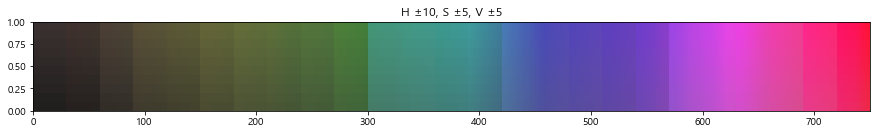

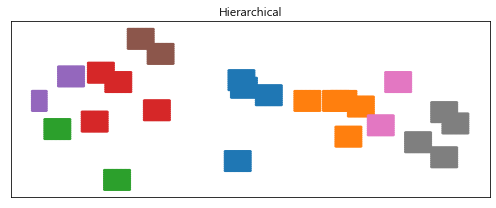

0.49


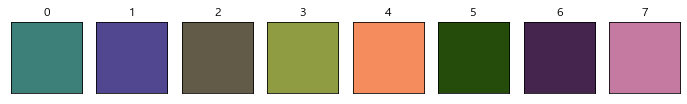

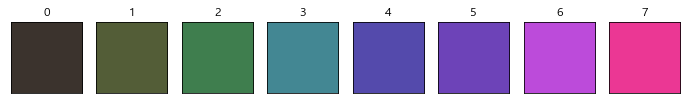

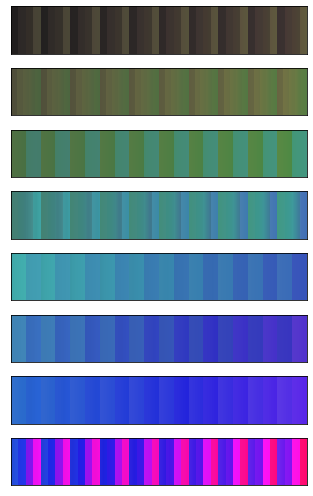

In [153]:
# 색상 데이터 확장 & 클러스터링 성능비교용 데이터셋 생성
## color_generator용 변수
ctrl, scale = [10, 5], [20, 10] # [H조정, SV조정], [H규모, SV규모]

hsv = [[1, 55, 98], [50, 44, 75], [55, 70, 45], [87, 88, 35], [103, 80, 25],
       [170, 62, 54], [221, 55, 56], [20, 40, 39], [331, 49, 67], [280, 42, 31],
       [168, 66, 86], [68, 13, 38], [244, 55, 18], [69, 65, 55], [331, 25, 85],
       [190, 58, 20], [250, 55, 55], [310, 33, 90], [340, 43, 68], [100, 50, 70],
       [31, 68, 96], [165, 23, 41], [264, 52, 88], [254, 36, 66], [294, 65, 30]] # 테스트용 


# hsv = [[1, 55, 98], [50, 44, 75], [55, 70, 45], [87, 88, 35], [103, 80, 25],
#        [170, 62, 54], [221, 55, 56], [20, 40, 39], [331, 49, 67], [280, 42, 31],
#        [168, 66, 86], [68, 13, 38], [244, 55, 18], [69, 65, 55], [331, 25, 85],
#        [190, 58, 20], [250, 55, 55], [310, 33, 90], [340, 43, 68], [100, 50, 70],
#        [31, 68, 96], [165, 23, 41], [264, 52, 88], [254, 36, 66], [294, 65, 30],
#        [65, 54, 32], [135, 22, 66], [178, 65, 25], [174, 65, 3], [301, 25, 35]] # 테스트용 

HSV = color_generator(hsv, ctrl, scale)
# performance = color_clustering(color_generator(hsv, ctrl, scale), len(hsv))
performance = color_clustering(HSV, len(hsv), scale)
print(performance[0])


## 중앙값 시각화
centroid = []
label = []
for i in range(performance[2].shape[0]):
    centroid.append(list(performance[2][i]))
    label.append(i)
show_colors(centroid, label)

## 평균값 시각화
avg_color = []
label = []
for i in range(len(performance[3])):
    avg_color.append(list(performance[3][i]))
    label.append(i)
show_colors(avg_color, label)


## 제너레이팅 데이터 + 예측값
pred = performance[1].reshape(scale[1], scale[0]*len(hsv))
hsv_check = np.sort(np.dstack((pred, HSV[:, :, 0]/359, HSV[:, :, 1:3]/100)), axis=1)
# hsv2avg = np.sort(np.dstack((pred, HSV)), axis=1)
# for i in range(n_clusters):
#     avg = np.mean(hsv2avg[hsv2avg[:, :, 0]==i].reshape(1, hsv2avg[hsv2avg[:, :, 0]==i].shape[0], 5)[:, :, 1:4], axis=1)
#     print(i,"번", avg)

## 
plt.figure(figsize=(7, 7))
plot_num = 1

n_ctrl = 7
if len(hsv)/n_ctrl <= 2:
    if len(hsv) < 5:
        n_clusters = len(hsv)
    else:
        n_clusters = 5
else:
    n_clusters = (len(hsv)//n_ctrl)+5

for i in range(n_clusters):
    rgb_check = hsv_to_rgb(np.sort(hsv_check[hsv_check[:, :, 0]==i].reshape(1, hsv_check[hsv_check[:, :, 0]==i].shape[0], 4)[:, :, 1:4]))
    
    plt.subplot(n_clusters, 1, plot_num)
    
    plt.imshow(rgb_check, origin="lower", extent=[0, 500, 0, 1], aspect=80)
    plt.xticks(())
    plt.yticks(())
    plt.grid(False)
    plot_num += 1

plt.tight_layout()
plt.show()

In [149]:
# ## 색 샘플 데이터 군집화용 데이터조정_데이터셋 형태별 성능 비교 시 사용

# def clustering_dataset(HSV):
#     x_size = HSV.shape[0]*HSV.shape[1]
#     y_size = HSV.shape[2]

#     blobs = HSV[:, :, :3].reshape(x_size, y_size-1), HSV[:, :, 3].reshape(x_size)
#     anisotropic = HSV[:, :, :3].reshape(x_size, y_size-1), HSV[:, :, 3].reshape(x_size)
#     varied = HSV[:, :, :3].reshape(x_size, y_size-1), HSV[:, :, 3].reshape(x_size)
#     noisy_circles = HSV[:, :, :3].reshape(x_size, y_size-1), HSV[:, :, 3].reshape(x_size)
#     noisy_moons = HSV[:, :, :3].reshape(x_size, y_size-1), HSV[:, :, 3].reshape(x_size)
#     no_structure = HSV[:, :, :3].reshape(x_size, y_size-1), None

#     datasets = {
#         "같은 크기의 원형": blobs,
#         "같은 크기의 타원형": anisotropic, 
#         "다른 크기의 원형": varied, 
#         "초승달": noisy_moons, 
#         "동심원": noisy_circles, 
#         "비구조화": no_structure
#     }
    

#     print(blobs[0].shape, blobs[1].shape)
#     print(anisotropic[0].shape, anisotropic[1].shape)
#     print(varied[0].shape, varied[1].shape)
#     print(noisy_circles[0].shape, noisy_circles[1].shape)
#     print(noisy_moons[0].shape, noisy_moons[1].shape)
#     print(no_structure[0].shape)
    
#     return datasets

In [3]:
# def clustering_test(datasets, n_hsv):
#     plt.figure(figsize=(11, 11))
#     plot_num = 1
#     ARI = [] # 성능평가(조정랜드지수) 담을 변수

#     for i, (data_name, (X, y)) in enumerate(datasets.items()):
#         if n_hsv < 5:
#             n_clusters = n_hsv
#         else:
#             n_clusters = 5

#         X = StandardScaler().fit_transform(X)

#         two_means = MiniBatchKMeans(n_clusters=n_clusters)
#         dbscan = DBSCAN(eps=0.5, algorithm='ball_tree') # 'auto', 'ball_tree', 'kd_tree', 'brute'
#         spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors') #'nearest_neighbors':안됨, 'precomputed', 'rbf':안됨
#         ward = AgglomerativeClustering(n_clusters=n_clusters)
#         affinity_propagation = AffinityPropagation(damping=0.9) # 배열사이즈 preference=-200
#         clustering_algorithms = (
#             ('K-Means', two_means),
#             ('DBSCAN', dbscan),
#             ('Hierarchical Clustering', ward),
#             ('Affinity Propagation', affinity_propagation),
#             ('Spectral Clustering', spectral),
#         )

#         ari = []
#         for j, (name, algorithm) in enumerate(clustering_algorithms):
#             with ignore_warnings(category=UserWarning):
#                 algorithm.fit(X)
#             if hasattr(algorithm, 'labels_'):
#                 y_pred = algorithm.labels_.astype(np.int)
#             else:
#                 y_pred = algorithm.predict(X)

#             if data_name != "비구조화":
#                 ari.append(round(silhouette_samples(X, y_pred), 2)) # 실루엣계수 산출
#             plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
#             if i == 0:
#                 plt.title(name)
#             if j == 0:
#                 plt.ylabel(data_name)
#             colors = plt.cm.tab10(np.arange(50, dtype=int))
#             plt.scatter(X[:, 0], X[:, 1], s=5, color=colors[y_pred]) # 여기서 인덱스 오류 나면 윗줄 차트색 범위 바꾸기
#             plt.xlim(-2.5, 2.5)
#             plt.ylim(-2.5, 2.5)
#             plt.xticks(())
#             plt.yticks(())
#             plot_num += 1

#         if data_name != "비구조화":
#             ARI.append(ari)


#     plt.tight_layout()
#     plt.show()
    
#     return pd.DataFrame(ARI, index=["같은 크기의 원형", "같은 크기의 타원형", "다른 크기의 원형", "초승달", "동심원"], columns=['K-Means', 'DBSCAN', 'Hierarchical Clustering', 'Affinity Propagation', 'Spectral Clustering']), y_pred

In [233]:
# ## Hierarchical Clustering

# def clustering_test(datasets, n_hsv):
#     plt.figure(figsize=(7, 11))
#     plot_num = 1
#     ARI = [] # 성능평가(조정랜드지수) 담을 변수

#     for i, (data_name, (X, y)) in enumerate(datasets.items()):
#         if n_hsv < 5:
#             n_clusters = n_hsv
#         elif n_hsv//4 > 5:
#             n_clusters = n_hsv//4
#         else:
#             n_clusters = 5

#         X = StandardScaler().fit_transform(X)

#         ward_2 = AgglomerativeClustering(n_clusters=n_clusters, affinity="euclidean") # Ward는 유클리드만 쓸 수 있
#         clustering_algorithms = (
#             ('Hierarchical', ward_2),
#         )

#         ari = []
#         for j, (name, algorithm) in enumerate(clustering_algorithms):
#             with ignore_warnings(category=UserWarning):
#                 algorithm.fit(X)
#             if hasattr(algorithm, 'labels_'):
#                 y_pred = algorithm.labels_.astype(np.int)
#             else:
#                 y_pred = algorithm.predict(X)

#             sample_silhouette_values = silhouette_samples(X, y_pred) # 실루엣계수 산출
#             ari.append(round(sample_silhouette_values.mean(), 2)) # 실루엣계수 평균
                
#             plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
#             if i == 0:
#                 plt.title(name)
#             if j == 0:
#                 plt.ylabel(data_name)
#             colors = plt.cm.tab10(np.arange(50, dtype=int))
#             plt.scatter(X[:, 0], X[:, 1], s=5, color=colors[y_pred]) # 여기서 인덱스 오류 나면 윗줄 차트색 범위 바꾸기
#             plt.xlim(-2.5, 2.5)
#             plt.ylim(-2.5, 2.5)
#             plt.xticks(())
#             plt.yticks(())
#             plot_num += 1

#         ARI.append(ari)


#     plt.tight_layout()
#     plt.show()
    
#     return pd.DataFrame(ARI, index=["같은 크기의 원형", "같은 크기의 타원형", "다른 크기의 원형", "초승달", "동심원", "비구조화"], columns=['Hierarchical']), y_pred

In [171]:
## 성능비교 너 탈락~
# ## K-means

# def clustering_test(datasets, n_hsv):
#     plt.figure(figsize=(7, 11))
#     plot_num = 1
#     ARI = [] # 성능평가(조정랜드지수) 담을 변수

#     for i, (data_name, (X, y)) in enumerate(datasets.items()):
#         if n_hsv < 5:
#             n_clusters = n_hsv
#         else:
#             n_clusters = 5

#         X = StandardScaler().fit_transform(X)

#         means = MiniBatchKMeans(n_clusters=n_clusters)
#         clustering_algorithms = (
#             ('K-Means_2', means),
#         )

#         ari = []
#         for j, (name, algorithm) in enumerate(clustering_algorithms):
#             with ignore_warnings(category=UserWarning):
#                 algorithm.fit(X)
#             if hasattr(algorithm, 'labels_'):
#                 y_pred = algorithm.labels_.astype(np.int)
#             else:
#                 y_pred = algorithm.predict(X)

#             sample_silhouette_values = silhouette_samples(X, y_pred) # 실루엣계수 산출
#             ari.append(round(sample_silhouette_values.mean(), 2)) # 실루엣계수 평균
                
#             plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
#             if i == 0:
#                 plt.title(name)
#             if j == 0:
#                 plt.ylabel(data_name)
#             colors = plt.cm.tab10(np.arange(50, dtype=int))
#             plt.scatter(X[:, 0], X[:, 1], s=5, color=colors[y_pred]) # 여기서 인덱스 오류 나면 윗줄 차트색 범위 바꾸기
#             plt.xlim(-2.5, 2.5)
#             plt.ylim(-2.5, 2.5)
#             plt.xticks(())
#             plt.yticks(())
#             plot_num += 1

#         ARI.append(ari)


#     plt.tight_layout()
#     plt.show()
    
#     return pd.DataFrame(ARI, index=["같은 크기의 원형", "같은 크기의 타원형", "다른 크기의 원형", "초승달", "동심원", "비구조화"], columns=['means']), y_pred

In [162]:
## 성능비교 너 탈락~
# ## DBSCAN
# def clustering_test(datasets, n_hsv):
#     plt.figure(figsize=(7, 11))
#     plot_num = 1
#     ARI = [] # 성능평가(조정랜드지수) 담을 변수

#     for i, (data_name, (X, y)) in enumerate(datasets.items()):
#         if n_hsv < 5:
#             n_clusters = n_hsv
#         else:
#             n_clusters = 5

#         X = StandardScaler().fit_transform(X)

#         dbscan1_1 = DBSCAN(eps=0.5, algorithm='auto') # 'auto', 'ball_tree', 'kd_tree', 'brute'
# #         dbscan1_2 = DBSCAN(eps=0.7, algorithm='auto')
# #         dbscan2_1 = DBSCAN(eps=0.5, algorithm='ball_tree')
# #         dbscan2_2 = DBSCAN(eps=0.7, algorithm='ball_tree')
# #         dbscan3_1 = DBSCAN(eps=0.5, algorithm='kd_tree')
# #         dbscan3_2 = DBSCAN(eps=0.7, algorithm='kd_tree')
# #         dbscan4_1 = DBSCAN(eps=0.5, algorithm='brute')
# #         dbscan4_2 = DBSCAN(eps=0.7, algorithm='brute')
#         clustering_algorithms = (
#             ('DBSCAN_auto_1', dbscan1_1),
#         )

#         ari = []
#         for j, (name, algorithm) in enumerate(clustering_algorithms):
#             with ignore_warnings(category=UserWarning):
#                 algorithm.fit(X)
#             if hasattr(algorithm, 'labels_'):
#                 y_pred = algorithm.labels_.astype(np.int)
#             else:
#                 y_pred = algorithm.predict(X)

#             sample_silhouette_values = silhouette_samples(X, y_pred) # 실루엣계수 산출
#             ari.append(round(sample_silhouette_values.mean(), 2)) # 실루엣계수 평균
                
#             plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
#             if i == 0:
#                 plt.title(name)
#             if j == 0:
#                 plt.ylabel(data_name)
#             colors = plt.cm.tab10(np.arange(50, dtype=int))
#             plt.scatter(X[:, 0], X[:, 1], s=5, color=colors[y_pred]) # 여기서 인덱스 오류 나면 윗줄 차트색 범위 바꾸기
#             plt.xlim(-2.5, 2.5)
#             plt.ylim(-2.5, 2.5)
#             plt.xticks(())
#             plt.yticks(())
#             plot_num += 1

#         ARI.append(ari)


#     plt.tight_layout()
#     plt.show()
    
#     return pd.DataFrame(ARI, index=["같은 크기의 원형", "같은 크기의 타원형", "다른 크기의 원형", "초승달", "동심원", "비구조화"], columns=['DBSCAN']), y_pred

In [127]:
## 성능비교 너 탈락~
# ## Affinity Propagation
# def clustering_test(datasets, n_hsv):
#     plt.figure(figsize=(7, 11))
#     plot_num = 1
#     ARI = [] # 성능평가(조정랜드지수) 담을 변수

#     for i, (data_name, (X, y)) in enumerate(datasets.items()):
#         if n_hsv < 5:
#             n_clusters = n_hsv
#         else:
#             n_clusters = 5

#         X = StandardScaler().fit_transform(X)

#         affinity_propagation2 = AffinityPropagation(damping=0.9) # 선호도 preference=-200
#         affinity_propagation3 = AffinityPropagation(damping=0.95)
# #         affinity_propagation4 = AffinityPropagation(damping=0.7)
# #         affinity_propagation5 = AffinityPropagation(damping=0.8)
# #         affinity_propagation6 = AffinityPropagation(damping=0.9)
#         clustering_algorithms = (
#             ('Affinity Propagation', affinity_propagation2),
#             ('Affinity Propagation', affinity_propagation3),
# #             ('Affinity Propagation', affinity_propagation4),
# #             ('Affinity Propagation', affinity_propagation5),
# #             ('Affinity Propagation', affinity_propagation6),
#         )

#         ari = []
#         for j, (name, algorithm) in enumerate(clustering_algorithms):
#             with ignore_warnings(category=UserWarning):
#                 algorithm.fit(X)
#             if hasattr(algorithm, 'labels_'):
#                 y_pred = algorithm.labels_.astype(np.int)
#             else:
#                 y_pred = algorithm.predict(X)

# #             sample_silhouette_values = silhouette_samples(X, y_pred) # 실루엣계수 산출
# #             ari.append(round(sample_silhouette_values.mean(), 2)) # 실루엣계수 평균
                
#             plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
#             if i == 0:
#                 plt.title(name)
#             if j == 0:
#                 plt.ylabel(data_name)
#             colors = plt.cm.tab10(np.arange(200, dtype=int))
#             plt.scatter(X[:, 0], X[:, 1], s=5, color=colors[y_pred]) # 여기서 인덱스 오류 나면 윗줄 차트색 범위 바꾸기
#             plt.xlim(-2.5, 2.5)
#             plt.ylim(-2.5, 2.5)
#             plt.xticks(())
#             plt.yticks(())
#             plot_num += 1

#         ARI.append(ari)


#     plt.tight_layout()
#     plt.show()
    
#     return pd.DataFrame(ARI, index=["같은 크기의 원형", "같은 크기의 타원형", "다른 크기의 원형", "초승달", "동심원", "비구조화"], columns=['Affinity Propagation', 'Affinity Propagation']), y_pred

In [231]:
## 성능비교 너 탈락~
# ## Spectral Clustering

# def clustering_test(datasets, n_hsv):
#     plt.figure(figsize=(7, 11))
#     plot_num = 1
#     ARI = [] # 성능평가(조정랜드지수) 담을 변수

#     for i, (data_name, (X, y)) in enumerate(datasets.items()):
#         if n_hsv < 5:
#             n_clusters = n_hsv
#         elif n_hsv//4 > 5:
#             n_clusters = n_hsv//4
#         else:
#             n_clusters = 5

#         X = StandardScaler().fit_transform(X)

#         spectral_n_2 = SpectralClustering(n_clusters=n_clusters, affinity='rbf') #'nearest_neighbors':, 'precomputed', 'rbf'
#         clustering_algorithms = (
#             ('Spectral Clustering', spectral_n_2),
#         )

#         ari = []
#         for j, (name, algorithm) in enumerate(clustering_algorithms):
#             with ignore_warnings(category=UserWarning):
#                 algorithm.fit(X)
#             if hasattr(algorithm, 'labels_'):
#                 y_pred = algorithm.labels_.astype(np.int)
#             else:
#                 y_pred = algorithm.predict(X)

#             sample_silhouette_values = silhouette_samples(X, y_pred) # 실루엣계수 산출
#             ari.append(round(sample_silhouette_values.mean(), 2)) # 실루엣계수 평균
                
#             plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
#             if i == 0:
#                 plt.title(name)
#             if j == 0:
#                 plt.ylabel(data_name)
#             colors = plt.cm.tab10(np.arange(50, dtype=int))
#             plt.scatter(X[:, 0], X[:, 1], s=5, color=colors[y_pred]) # 여기서 인덱스 오류 나면 윗줄 차트색 범위 바꾸기
#             plt.xlim(-2.5, 2.5)
#             plt.ylim(-2.5, 2.5)
#             plt.xticks(())
#             plt.yticks(())
#             plot_num += 1

#         ARI.append(ari)


#     plt.tight_layout()
#     plt.show()
    
#     return pd.DataFrame(ARI, index=["같은 크기의 원형", "같은 크기의 타원형", "다른 크기의 원형", "초승달", "동심원", "비구조화"], columns=['Spectral']), y_pred

In [76]:
def color_generator(prdt_hsv_list, ctrl, scale):
    # hsv_list = [[h1, s1, v1], [h2, s2, v3], ...]
    # ctrl = [H조정값, SV조정값]
    # scale = [H확장규모, SV확장규모]
    # 라벨?상품코드? 있어야할지도 모르겠음
    
    ## Gray tone Filtering : 1. 채도S 명도V 모두 20이하 2, 채도S+(100-명도V)가 20이하 3. (100-채도S)+명도V가 20이하
    hsv_list = [] # 회색조 필터링 hsv 담을 변수
    
    ## extend color scale
    for hsv, i in zip(prdt_hsv_list, range(len(prdt_hsv_list))):
        if i == 0:
            HSV = np.array([[hsv]])
        else:
#             HSV_n = np.array([[hsv]])
            HSV = np.hstack((HSV, np.array([[hsv]])))
    
    # 제너레이팅 데이터 시각화
    hsv = np.dstack((HSV[:, :, 0]/359, HSV[:, :, 1]/100, HSV[:, :, 2]/100))
    rgb = hsv_to_rgb(hsv)
    
    plt.figure(figsize=(15, 2))

    plt.imshow(rgb, origin="lower", extent=[0, 750, 0, 1], aspect=80)
    plt.title("H ±{}, S ±{}, V ±{}".format(ctrl[0], ctrl[1],ctrl[1]))
    plt.grid(False)
    
    return HSV

In [83]:
## Clustering 구매상품 데이터 적용용

def color_clustering(HSV, n_hsv):
    ## Cluster 개수
    n_ctrl = 7
    if n_hsv/n_ctrl <= 2:
        if n_hsv < 5:
            n_clusters = n_hsv
        else:
            n_clusters = 5
    else:
        n_clusters = (n_hsv//n_ctrl)+5
    
    
    ## Clustering Dataset 생성
    x_size = HSV.shape[0]*HSV.shape[1]
    y_size = HSV.shape[2]

#     X, y = HSV[:, :, :3].reshape(x_size, y_size-1), HSV[:, :, 3].reshape(x_size)
    X = HSV[:, :, :3].reshape(x_size, y_size)
    
#     X = StandardScaler().fit_transform(X)
    
    
    ## 알고리즘 선정 : Hierarchical
    algorithm = AgglomerativeClustering(n_clusters=n_clusters, affinity="euclidean")
    
    
    ## Clustering 실행
    with ignore_warnings(category=UserWarning):
        algorithm.fit(X)
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(X)
    
    ## centroid(중심점)찾기
    clf = NearestCentroid()
    centroid = clf.fit(X, y_pred).centroids_
    
    
    ## 실루엣계수 산출
    sample_silhouette_values = silhouette_samples(X, y_pred)
    silhouette_avg = round(sample_silhouette_values.mean(), 2)
    
    
    ## 군집 시각화
    plt.figure(figsize=(7, 4))
    colors = plt.cm.tab10(np.arange(50, dtype=int))
    plt.scatter(X[:, 0], X[:, 1], s=5, color=colors[y_pred]) # 여기서 인덱스 오류 나면 윗줄 차트색 범위 바꾸기
    plt.title("Hierarchical")
#     plt.xlim(-2.5, 2.5)
#     plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    plt.tight_layout()
    plt.show()
    
    return silhouette_avg, y_pred, centroid

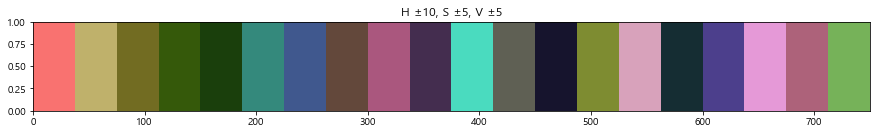

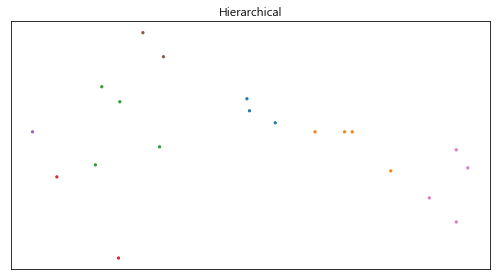

0.38


ValueError: cannot reshape array of size 20 into shape (10,400)

In [84]:
# 색상 데이터 확장 & 클러스터링 성능비교용 데이터셋 생성
## color_generator용 변수
ctrl, scale = [10, 5], [20, 10] # [H조정, SV조정], [H규모, SV규모]

hsv = [[1, 55, 98], [50, 44, 75], [55, 70, 45], [87, 88, 35], [103, 80, 25],
       [170, 62, 54], [221, 55, 56], [20, 40, 39], [331, 49, 67], [280, 42, 31],
       [168, 66, 86], [68, 13, 38], [244, 55, 18], [69, 65, 55], [331, 25, 85],
       [190, 58, 20], [250, 55, 55], [310, 33, 90], [340, 43, 68], [100, 50, 70]] # 테스트용 


# hsv = [[1, 55, 98], [50, 44, 75], [55, 70, 45], [87, 88, 35], [103, 80, 25],
#        [170, 62, 54], [221, 55, 56], [20, 40, 39], [331, 49, 67], [280, 42, 31],
#        [168, 66, 86], [68, 13, 38], [244, 55, 18], [69, 65, 55], [331, 25, 85],
#        [190, 58, 20], [250, 55, 55], [310, 33, 90], [340, 43, 68], [100, 50, 70],
#        [31, 68, 96], [165, 23, 41], [264, 52, 88], [254, 36, 66], [294, 65, 30],
#        [65, 54, 32], [135, 22, 66], [178, 65, 25], [174, 65, 3], [301, 25, 35]] # 테스트용 

HSV = color_generator(hsv, ctrl, scale)
# performance = color_clustering(color_generator(hsv, ctrl, scale), len(hsv))
performance = color_clustering(HSV, len(hsv))
print(performance[0])

## 제너레이팅 데이터 + 예측값
print(performance[1])
pred = performance[1].reshape(scale[1], scale[0]*len(hsv))
hsv_check = np.sort(np.dstack((pred, HSV[:, :, 0]/359, HSV[:, :, 1:3]/100, HSV[:, :, 3])), axis=1)

## 
plt.figure(figsize=(7, 7))
plot_num = 1

n_ctrl = 7
if len(hsv)/n_ctrl <= 2:
    if len(hsv) < 5:
        n_clusters = len(hsv)
    else:
        n_clusters = 5
else:
    n_clusters = (len(hsv)//n_ctrl)+5

for i in range(n_clusters):
    rgb_check = hsv_to_rgb(np.sort(hsv_check[hsv_check[:, :, 0]==i].reshape(1, hsv_check[hsv_check[:, :, 0]==i].shape[0], 5)[:, :, 1:4]))
    
    plt.subplot(n_clusters, 1, plot_num)
    
    plt.imshow(rgb_check, origin="lower", extent=[0, 500, 0, 1], aspect=80)
    plt.xticks(())
    plt.yticks(())
    plt.grid(False)
    plot_num += 1

plt.tight_layout()
plt.show()

centroid = []
label = []
for i in range(performance[2].shape[0]):
    centroid.append(list(performance[2][i]))
    label.append(i)

show_colors(centroid, label)